# Pyro Crash Course – Notebook 5: Hierarchical latent variables

We now go fully Bayesian and hierarchical: This notebook introduces **latent random variables for each device** into our sensor calibration model. This enables inference with **posterior mean and covariance** different for each sensor thereby introducing multimodality into the inferred latent posteriors.

### 🔙 Quick Recap

In *Notebook 4*, we used one global offset/scale pair for all devices.  
Here, we expand that to per-device latent parameters:

$$
T_{\text{meas}}[i, j] = \alpha_0^{(i)} + \alpha_1^{(i)} \cdot T_{\text{true}}[i, j] + \text{noise}
$$

Each pair $(\alpha_0^{(i)}, \alpha_1^{(i)})$ is drawn from a shared prior:

$$
\alpha^{(i)} \sim \mathcal{N}\left(\begin{bmatrix} 0 \\ 1 \end{bmatrix}, 0.1^2 I\right)
$$


---

### 🎯 Learning Goals

- Implement a **hierarchical Bayesian model** with sensor-specific latents  
- Learn **per-sensor posterior distributions** (mean + covariance)  
- Use **multivariate normal** as a variational family with full covariance  
- Detect **model misspecification or sensor anomalies** via the posterior

---

For this, do the following:
   1. Imports and definitions  
   2. Build model and guide  
   3. Perform inference  
   4. Interpretations and illustrations


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/atlasoptimization/tutorials/blob/master/pyro/pyro_crash_course/pyro_cc_5_model_3.ipynb
)

> ⚠️ You do *not* need to sign in with GitHub to run this notebook.  
> Just click the Colab badge and start executing.

📎 Input: `sensor_measurements.csv` (generated in `pyro_cc_1_hello_dataset`) 

📌 Next: `pyro_cc_6_model_4` introduces a discrete distribution that allows classifying a a faulty device


This notebook and series are created for educational purposes by  [Dr. Jemil Avers Butt, Atlas Optimization GmbH](https://www.atlasoptimization.com).


---

# Start of Notebook 5

## 1. Imports and definitions

No changes here. Just setup — `pyro`, `torch`, CSV import, reshaping, and seed.


📌 This is the first notebook that **introduces per-device latent variables**.


In [1]:
"""
    1. Imports and definitions
"""

# i) Imports
# If you run this in Colab, you might get an import error as pyro is not
# installed by default. In that case, uncomment the following command.
# !pip install pyro-ppl
import pyro
import torch
import pandas
import matplotlib.pyplot as plt


# ii) Definitions
!wget https://raw.githubusercontent.com/atlasoptimization/tutorials/master/pyro/pyro_crash_course/sensor_measurements.csv
measurement_df = pandas.read_csv("sensor_measurements.csv")
n_device = measurement_df["sensor_id"].nunique()
n_measure = measurement_df["time_step"].nunique()

# Read out T_true and T_meas: the true temperature and the measured temperature
T_true = torch.tensor(measurement_df["T_true"].values).reshape(n_device, n_measure)
T_meas = torch.tensor(measurement_df["T_measured"].values).reshape(n_device, n_measure)

# Assume standard deviation
sigma_T_meas = 0.3

# Fix random seed
pyro.set_rng_seed(0)


--2025-05-09 00:22:53--  https://raw.githubusercontent.com/atlasoptimization/tutorials/master/pyro/pyro_crash_course/sensor_measurements.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8001::154, 2606:50c0:8002::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12270 (12K) [text/plain]
Saving to: ‘sensor_measurements.csv.2’

sensor_measurements 100%[===================>]  11.98K  3.93KB/s    in 3.0s    

2025-05-09 00:23:07 (3.93 KB/s) - ‘sensor_measurements.csv.2’ saved [12270/12270]



---

## 2. Build Model and Guide

### 🔧 The Model

We now treat each sensor's offset and scale as latent variables:  
Their values are *sampled inside* a Pyro plate over devices.

- The prior: $\alpha_i \sim \mathcal{N}([0, 1], 0.1^2 I)$  
- The likelihood:  
  $T_{\text{meas}}[i,j] \sim \mathcal{N}(\alpha^{(i)}_0 + \alpha^{(i)}_1 T_{\text{true}}[i,j], \sigma)$


In [2]:
"""
    2. Build model and guide
"""

# i) Define the model
# Define priors
mu_alpha = torch.tensor([0.0, 1.0])
Sigma_alpha = torch.tensor([[0.1**2,0], [0, 0.1**2]])

# Build the model in pyro
def model(input_vars = T_true, observations = None):
    # Define latent dist, then sample latents alpha inside of device_plate
    alpha_dist = pyro.distributions.MultivariateNormal(loc = mu_alpha,
                                                covariance_matrix = Sigma_alpha)
    
    # Independence in first dim of alpha_dist, sample n_device times
    with pyro.plate('device_plate', size = n_device, dim = -1):
        # We sample alpha from a multivariate normal prior
        alpha = pyro.sample('alpha', alpha_dist)
    
    # Build the observation distribution
    # This requires a bit of reshaping to achieve broadcastable shapes.
    mean_obs = (alpha[:,0].unsqueeze(1)) + (alpha[:,1].unsqueeze(1))*T_true
    obs_dist = pyro.distributions.Normal(loc = mean_obs, scale = sigma_T_meas)
    
    # Sample from this distribution and declare the samples independent in the
    # first two dims. 
    with pyro.plate('device_plate', dim = -2):
        with pyro.plate('measure_plate', dim = -1):
            obs = pyro.sample('observations', obs_dist, obs = observations)
    
    return obs


### 🎯 Key Implementation Notes

- `pyro.sample('alpha', ...)` occurs **within the device plate**  
  ⇒ one draw per sensor, shape `[n_device, 2]`

- Reshaping is used to broadcast the model linearly:  
  `mean_obs = alpha[:,0].unsqueeze(1) + alpha[:,1].unsqueeze(1) * T_true`


### 🧠 The Guide

We approximate each latent pair $\alpha_i = (\alpha_0^{(i)}, \alpha_1^{(i)})$  
with its **own** variational multivariate normal distribution:

$$
q(\alpha^{(i)}) = \mathcal{N}(\mu_i, \Sigma_i)
$$

- We store $\mu_i$ and $\Sigma_i$ using `pyro.param`
- Each $\Sigma_i$ is a full covariance matrix (2x2), per device
- Constraint: `positive_definite` ensures valid covariance
- A diagonal jitter term `+ 0.001 * I` improves numerical stability


In [3]:
# ii) Build the guide

# Build the guide
def guide(input_vars = T_true, observations = None):
    # Per-device means and scales (shape [n_device, 2])
    mu_alpha_post = pyro.param('mu_alpha_post', torch.tensor([0,1.0]).unsqueeze(0).expand([n_device,2]))
    sigma_alpha_post = (pyro.param('sigma_alpha_post', 0.1 * (torch.eye(2).unsqueeze(0)).expand([n_device,2,2]),
                             constraint=pyro.distributions.constraints.positive_definite) 
                        + 0.001 * torch.eye(2))
    # We add 1e-3 on the diagonal of the covariance matrix to avoid numerical issues
    # related to positive definiteness tests.

    with pyro.plate('device_plate', size=n_device, dim=-1):
        # Multivariate Gaussian for each device (allow for correlations)
        alpha = pyro.sample('alpha', pyro.distributions.MultivariateNormal(loc = mu_alpha_post,
                                        covariance_matrix = sigma_alpha_post))

    return alpha


### 📈 Visualizing the Model Structure

We use `pyro.render_model` to visualize both the **generative model** and the **guide**:

- The model shows `alpha` **inside the device plate** as a latent variable  
- The guide shows `alpha` as sampled from learned `mu` and `Sigma`, also plate-scoped


In [4]:
# iii) Illustrate model and guide
graphical_model = pyro.render_model(model = model, model_args= (T_true,),
                                    render_distributions=True,
                                    render_params=True)
graphical_guide = pyro.render_model(model = guide, model_args= (T_true,),
                                    render_distributions=True,
                                    render_params=True)


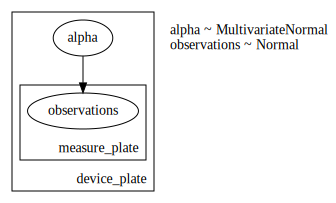

In [5]:
graphical_model

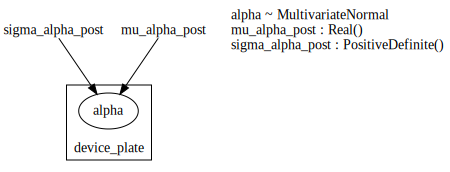

In [6]:
graphical_guide

In [7]:
# iv) Record example outputs of model and guide prior to training
n_model_samples = 10
n_guide_samples = 1000  

predictive = pyro.infer.Predictive
prior_predictive_pretrain = predictive(model, num_samples = n_model_samples)()['observations']
posterior_pretrain = predictive(guide, num_samples = n_guide_samples)()['alpha']
posterior_predictive_pretrain = predictive(model, guide = guide, num_samples = n_model_samples)()['observations']


---

## 3. Perform Inference

We perform variational inference using `SVI` and `Trace_ELBO`.  
Since we’re sampling many latent variables (2 per device), we increase:

- `num_particles=20` → reduces noise in the stochastic ELBO
- `n_steps=1000` → ensures convergence of many posterior parameters


In [8]:
"""
    3. Perform inference
"""

# i) Set up inference
adam = pyro.optim.Adam({"lr": 0.01})
elbo = pyro.infer.Trace_ELBO(num_particles = 20)
svi = pyro.infer.SVI(model, guide, adam, elbo)

# ii) Perform svi
data = (T_true, T_meas)
loss_sequence = []
for step in range(1000):
    loss = svi.step(*data)
    loss_sequence.append(loss)
    if step %50 == 0:
        print(f'epoch: {step} ; loss : {loss}')
        

epoch: 0 ; loss : 85108.50167531101
epoch: 50 ; loss : 23693.886270862222
epoch: 100 ; loss : 15907.15841288072
epoch: 150 ; loss : 11680.203809162056
epoch: 200 ; loss : 9550.65069953253
epoch: 250 ; loss : 8026.226922328902
epoch: 300 ; loss : 8055.070809938564
epoch: 350 ; loss : 5762.561872763935
epoch: 400 ; loss : 4529.060484628828
epoch: 450 ; loss : 3564.994115249424
epoch: 500 ; loss : 3392.7036936252207
epoch: 550 ; loss : 3081.5770924279777
epoch: 600 ; loss : 3221.23861320117
epoch: 650 ; loss : 3074.4655887440586
epoch: 700 ; loss : 3178.385993310437
epoch: 750 ; loss : 2510.1895962380063
epoch: 800 ; loss : 2489.295453861943
epoch: 850 ; loss : 2403.3524367201553
epoch: 900 ; loss : 2291.5813533590012
epoch: 950 ; loss : 2414.922240793143


### 🧠 ELBO in the Hierarchical Setting

The Evidence Lower Bound (ELBO) now captures two terms:

$$
\text{ELBO} = \mathbb{E}_{q_\phi(z)}[\log p_\theta(x, z)] - \mathbb{E}_{q_\phi(z)}[\log q_\phi(z)]
$$

Compared to earlier models:

- The **likelihood term** requires marginalizing over per-device latent variables
- The **KL divergence** penalizes deviation between the posterior guide $q_\phi(z)$ and posterior $p(z|x)$

Because $q$ and $p$ are multivariate, we model **correlations** between offset and scale per device.
This allows more flexible and realistic posterior approximations.


In [9]:
# iii) Record example outputs of model and guide after training
prior_predictive_posttrain = predictive(model, num_samples = n_model_samples)()['observations']
posterior_posttrain = predictive(guide, num_samples = n_guide_samples)()['alpha']
posterior_predictive_posttrain = predictive(model, guide = guide, num_samples = n_model_samples)()['observations']


# iv) Additional investigations
model_trace = pyro.poutine.trace(model).get_trace(T_true, observations = T_meas)
guide_trace = pyro.poutine.trace(guide).get_trace(T_true, observations = T_meas)
print('These are the shapes inside of the model : \n {}'.format(model_trace.format_shapes()))
print('These are the shapes inside of the guide : \n {}'.format(guide_trace.format_shapes()))

# The parameters of the posterior are again stored in pyro's param_store
for name, value in pyro.get_param_store().items():
    print('Param : {}; Value : {}'.format(name, value))
    

These are the shapes inside of the model : 
     Trace Shapes:          
     Param Sites:          
    Sample Sites:          
device_plate dist       |  
            value     5 |  
       alpha dist     5 | 2
            value     5 | 2
observations dist 5 100 |  
            value 5 100 |  
These are the shapes inside of the guide : 
     Trace Shapes:        
     Param Sites:        
    mu_alpha_post   5 2  
 sigma_alpha_post 5 2 2  
    Sample Sites:        
device_plate dist     |  
            value   5 |  
       alpha dist   5 | 2
            value   5 | 2
Param : mu_alpha_post; Value : tensor([[ 1.2967,  1.1010],
        [-0.0517,  1.0472],
        [-0.1047,  1.0712],
        [-0.1147,  0.9345],
        [-0.1525,  0.9645]], requires_grad=True)
Param : sigma_alpha_post; Value : tensor([[[ 0.0356, -0.0019],
         [-0.0019,  0.0013]],

        [[ 0.0358,  0.0004],
         [ 0.0004,  0.0013]],

        [[ 0.0373, -0.0035],
         [-0.0035,  0.0016]],

        [[ 0.0357,

### 📐 Shape Overview

| Object | Shape | Meaning |
|--------|-------|---------|
| `T_true` / `T_meas` | `[n_device, n_measure]` | True/measured temperatures |
| `alpha` in model | `[n_device, 2]` | Latent offset and scale per device |
| `mu_alpha_post` | `[n_device, 2]` | Posterior mean of $(\alpha_0, \alpha_1)$ |
| `sigma_alpha_post` | `[n_device, 2, 2]` | Posterior covariance per device |
| `posterior_samples` | `[n_samples, n_device, 2]` | Draws from the guide |
| `posterior_predictive` | `[n_samples, n_device, n_measure]` | Simulated data conditioned on guide |


---

## 4. Interpretations and Illustrations

### 🔍 Notes on Optimization

- The ELBO loss is now **stochastic** and **noisy**
- You should see **noisy downward trend** in the loss curve
- Larger `num_particles` can help reduce variance, at the cost of runtime


Text(0, 0.5, 'value')

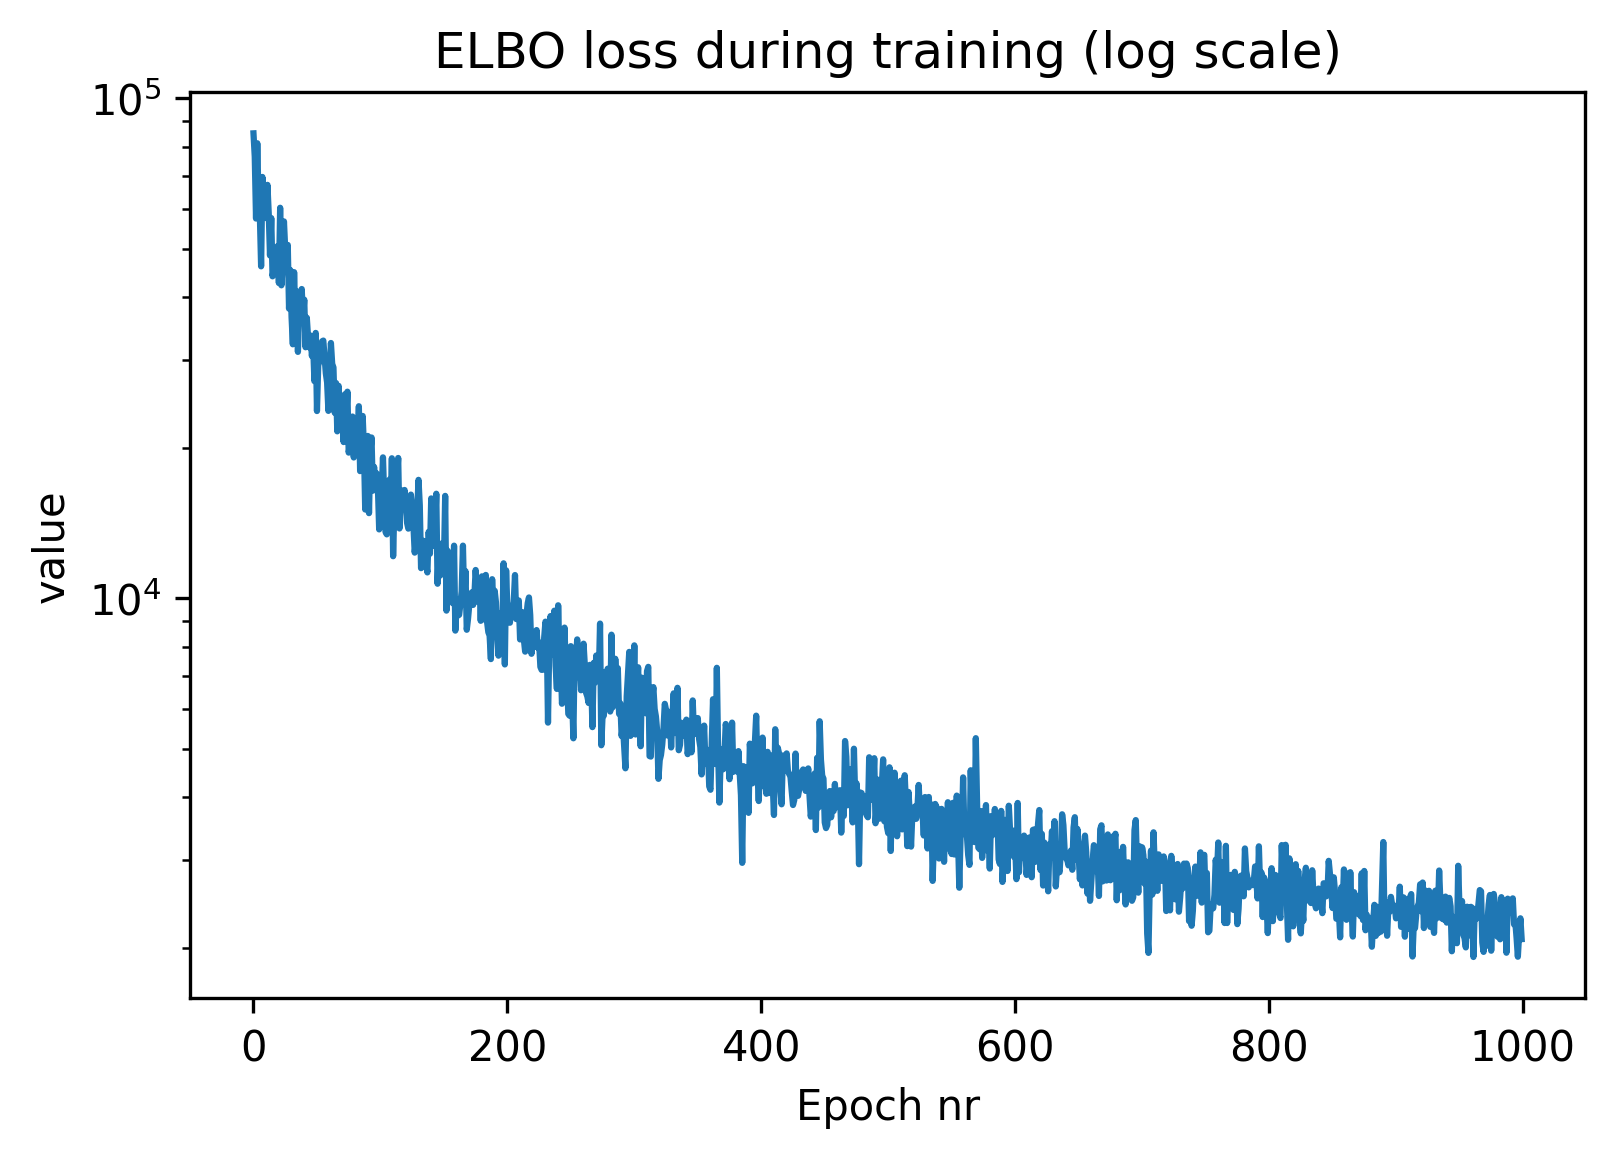

In [10]:
"""
    4. Interpretations and illustrations
"""

# i) Plot and print ELBO loss
plt.figure(1, dpi = 300)
plt.plot(loss_sequence)
plt.yscale("log")
plt.title('ELBO loss during training (log scale)')
plt.xlabel('Epoch nr')
plt.ylabel('value')


### 🔍 A look at the results

We now compare four things:

1. 📊 The real sensor measurements
2. 🎲 Samples from the **prior predictive distribution**
3. 🎯 Samples from the **posterior predictive distribution**
4. 🔍 Samples from the guide’s posterior $q(\alpha)$ (before and after training)

Each plot reveals how the model fits and adapts:

- Posterior predictive samples after training should match real data better
- The histogram of latent $(\alpha_0, \alpha_1)$ values shows how different sensors learn different calibrations


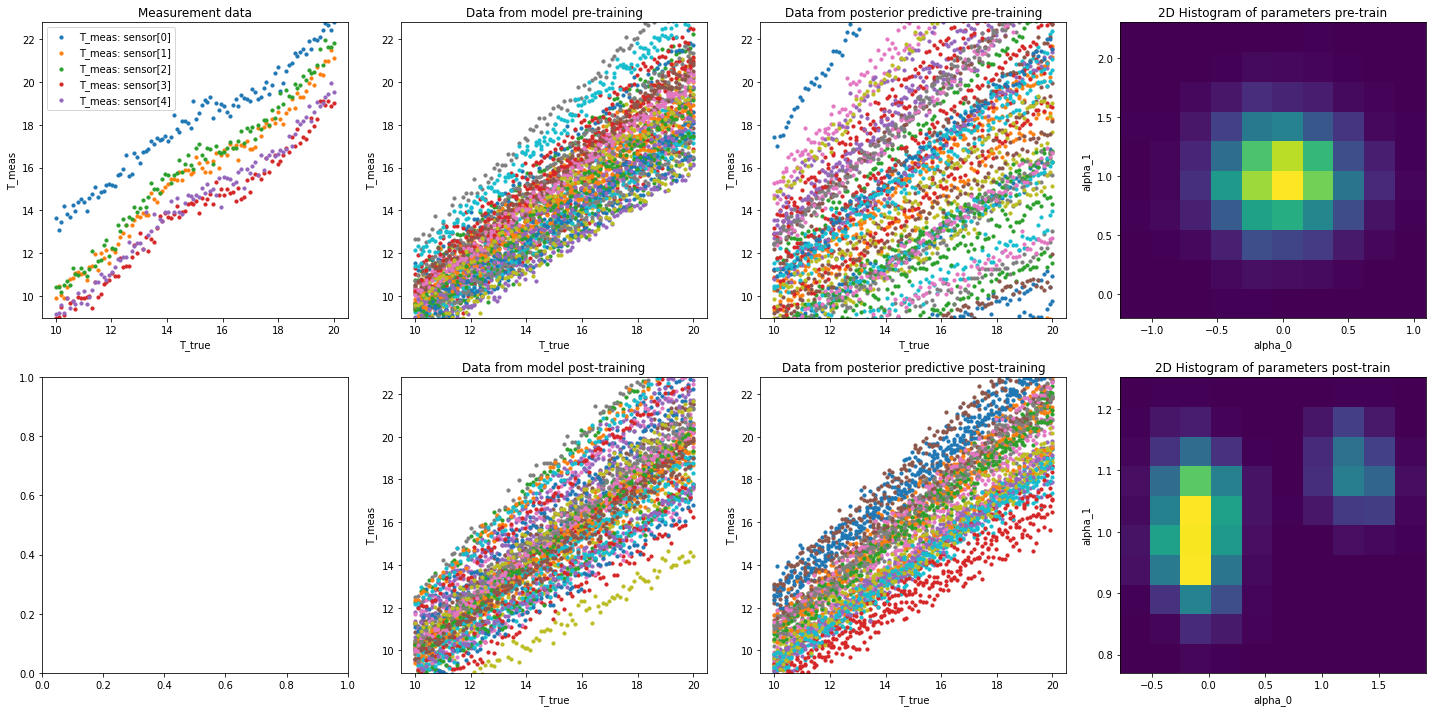

In [11]:
# ii) Compare model output and data

# Create the figure and 2x5 subplot grid
fig, axes = plt.subplots(2, 4, figsize=(20, 10), sharex=False, sharey=False)
# Global y-axis limits
y_min = T_meas.min()
y_max = T_meas.max()

# FIRST ROW
# First plot: measurement data
for i in range(n_device):
    axes[0,0].scatter(T_true[i,:], T_meas[i,:], s=10, label=f"T_meas: sensor[{i}]")
axes[0,0].set_title("Measurement data")
axes[0,0].set_xlabel("T_true")
axes[0,0].set_ylabel("T_meas")
axes[0,0].set_ylim(y_min, y_max)
axes[0,0].legend()

# Second plot: data produced by model pre-training
for k in range(n_model_samples):
    for i in range(n_device):
        axes[0,1].scatter(T_true[i,:], prior_predictive_pretrain[k,i,:], s=10, label=f"T_meas: sensor[{i}]")
axes[0,1].set_title("Data from model pre-training")
axes[0,1].set_xlabel("T_true")
axes[0,1].set_ylabel("T_meas")
axes[0,1].set_ylim(y_min, y_max)

# Third plot: data produced by posterior_predictive pre-training
for k in range(n_model_samples):
    for i in range(n_device):
        axes[0,2].scatter(T_true[i,:], posterior_predictive_pretrain[k,i,:], s=10, label=f"T_meas: sensor[{i}]")
axes[0,2].set_title("Data from posterior predictive pre-training")
axes[0,2].set_xlabel("T_true")
axes[0,2].set_ylabel("T_meas")
axes[0,2].set_ylim(y_min, y_max)

# Fourth plot: data produced by guide pre-training
axes[0,3].hist2d(posterior_pretrain[:,:,0].flatten().numpy(),
                 posterior_pretrain[:,:,1].flatten().numpy(),
                 bins=10, cmap='viridis')
axes[0,3].set_title("2D Histogram of parameters pre-train")
axes[0,3].set_xlabel("alpha_0")
axes[0,3].set_ylabel("alpha_1")

# SECOND ROW
# Second plot: data produced by model post-training
for k in range(n_model_samples):
    for i in range(n_device):
        axes[1,1].scatter(T_true[i,:], prior_predictive_posttrain[k,i,:], s=10, label=f"T_meas: sensor[{i}]")
axes[1,1].set_title("Data from model post-training")
axes[1,1].set_xlabel("T_true")
axes[1,1].set_ylabel("T_meas")
axes[1,1].set_ylim(y_min, y_max)

# Third plot: data produced by posterior_predictive post-training
for k in range(n_model_samples):
    for i in range(n_device):
        axes[1,2].scatter(T_true[i,:], posterior_predictive_posttrain[k,i,:], s=10, label=f"T_meas: sensor[{i}]")
axes[1,2].set_title("Data from posterior predictive post-training")
axes[1,2].set_xlabel("T_true")
axes[1,2].set_ylabel("T_meas")
axes[1,2].set_ylim(y_min, y_max)

# Fourth plot: data produced by guide post-training
axes[1,3].hist2d(posterior_posttrain[:,:,0].flatten().numpy(),
                 posterior_posttrain[:,:,1].flatten().numpy(),
                 bins=10, cmap='viridis')
axes[1,3].set_title("2D Histogram of parameters post-train")
axes[1,3].set_xlabel("alpha_0")
axes[1,3].set_ylabel("alpha_1")

plt.tight_layout()
plt.show()


### 🧠 Modeling Insight

This model brings us closer to **real-world heterogeneity**:

- Instead of assuming all sensors behave identically, we now let each sensor have its own calibration
- Inference automatically **discovers sensor-specific behavior**
- One sensor (visible in the 2D histogram) shows a strong **offset deviation**, suggesting a faulty sensor or outlier

📌 This sets the stage for **outlier detection** and **robust modeling**, which will be introduced in the next notebook.


---

## 🧾 Summary

### What Model 3 Adds

| Feature | Description |
|--------|-------------|
| 🧠 Model | Latent offset & scale **per device**, sampled from a prior |
| 🧭 Guide | One multivariate Gaussian per device for posterior over $(\alpha_0, \alpha_1)$ |
| 📊 Inference | SVI with `Trace_ELBO(num_particles=20)` |
| 🔎 Posterior | 5 latent variables → 5 guides → each has mean + full covariance |
| 📉 Loss behavior | ELBO gets noisier; convergence visible in posterior predictive |
| 💡 Takeaway | Model starts capturing **device-specific calibration** differences |


### Central learning experience

In this notebook, we:

✅ Defined a linear model where **each device has its own latent parameters** (offset, scale)  
✅ Used **Multivariate Normal priors** and sampled per-device parameters in a plate  
✅ Built a guide using **per-device multivariate Normal distributions** (with full covariance)  
✅ Used **SVI** to infer the latent posterior for each device  
✅ Visualized **prior predictive**, **posterior predictive**, and **posterior samples**  
✅ Observed how **variational inference adapts to sensor heterogeneity**

---

📌 In the next notebook, we’ll explore **discrete latent variables** to model **outlier sensors**  
(e.g., a switch that turns a faulty sensor on/off) using categorical or Bernoulli latent variables.
